In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl


In [2]:
def make_df(path):
    df = pd.read_csv(path)
    df = pd.DataFrame(df)
    return df

In [3]:
df_imdb = make_df("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [4]:
df_imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
df_imdb.nunique()

review       49582
sentiment        2
dtype: int64

In [6]:
df_imdb.isna().sum()

review       0
sentiment    0
dtype: int64

In [7]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


<Axes: xlabel='sentiment', ylabel='count'>

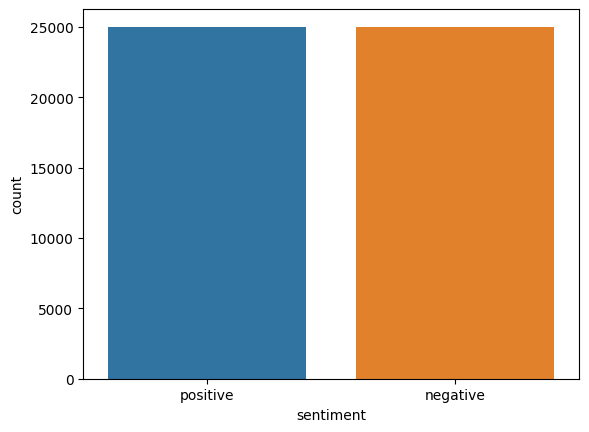

In [8]:
import seaborn as sns

sns.countplot(x = df_imdb['sentiment'])

### Data Visualization using word cloud.

In [9]:
from sklearn.preprocessing import LabelEncoder

sentences = df_imdb['review']
le = LabelEncoder()
df_imdb['sentiment'] = le.fit_transform(df_imdb['sentiment'])

(-0.5, 799.5, 799.5, -0.5)

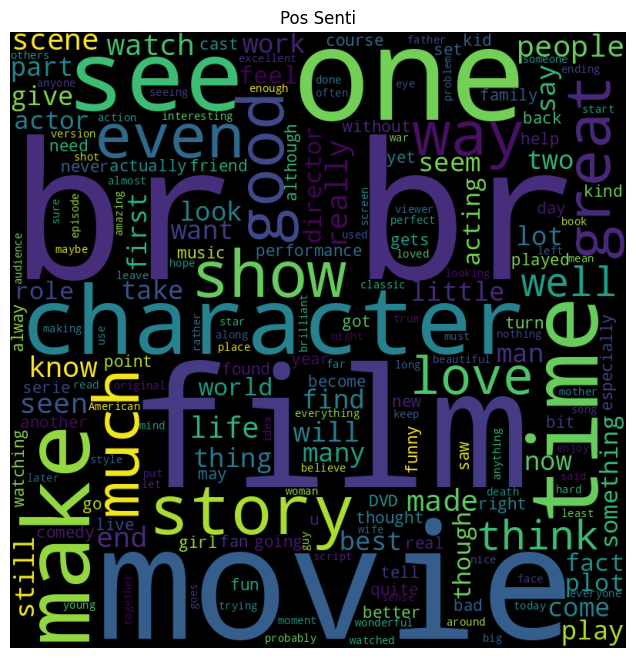

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# stopwords

stopwords = set(STOPWORDS)

pos=''.join(map(str, sentences[df_imdb['sentiment']==1]))
neg=''.join(map(str, sentences[df_imdb['sentiment']==0]))

wordcloud1 = WordCloud(width = 800, 
                        height = 800, 
                        background_color = 'black', 
                        stopwords = stopwords, 
                        min_font_size = 10).generate(pos)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Pos Senti')
plt.axis('off')

(-0.5, 799.5, 799.5, -0.5)

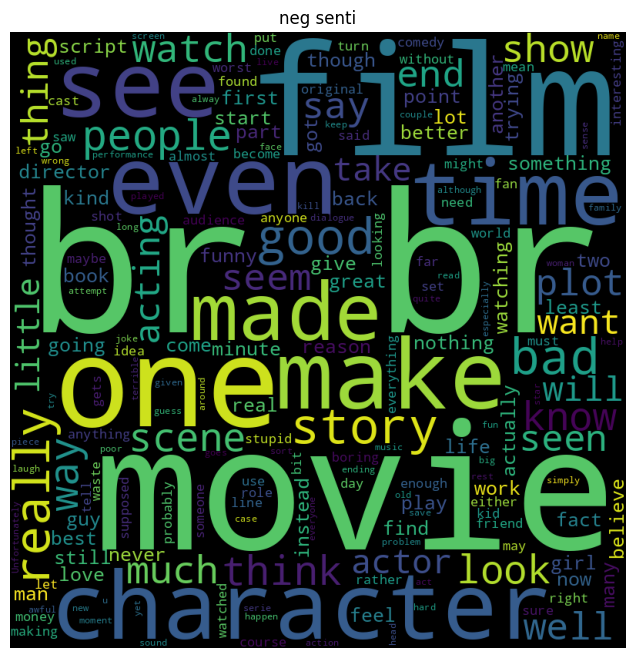

In [11]:
plt.figure(figsize=(8,8))
wordcloud2 = WordCloud(width=800,
                      height=800,
                      background_color='black',
                      stopwords=stopwords,
                      min_font_size=10).generate(neg)

plt.imshow(wordcloud2)
plt.title('neg senti')
plt.axis('off')


### There is a clear visual the 'br br' is used most times. Looking into the df_imdb, there are html inputs. This will affect sentiment analysis as it hold no sentimental value.

In [12]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# splitting train-test

labels=to_categorical(df_imdb['sentiment'],num_classes=2)
X_train, Y_train, X_test, Y_test = train_test_split(df_imdb['review'],labels,test_size=0.1,random_state=42)

In [15]:
# cleaning data, utilizing glove embeddings. For the purpose of misspelling, concated words, or emojis.

glove_embeddings= np.load('/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl',
                          allow_pickle=True)


In [16]:
# build vocab and count each vocab using function below

def vocab_build(review):
    comments = review.apply(lambda s: s.split()).values
    vocab={}
    
    for comment in comments:
        for word in comment:
            try:
                vocab[word]+=1
            except KeyError:
                vocab[word]=1
    return vocab

In [17]:
# Embedding Coverage. Tells how much % of the words in data are covered by the vocabulary.
# sorted_oov is list of words that needs text cleaning.

def embedding_coverage(review, embeddings):
    
    vocab=vocab_build(review)
    
    covered={}
    word_count={}
    oov={}
    covered_num=0
    oov_num=0
    
    for word in vocab:
        try:
            covered[word]=embedding[word]
            covered_num+=vocab[word]
            word_count[word]=vocab[word]
        except:
            oov[word]=vocab[word]
            oov_num+=oov[word]
            
    vocab_coverage=len(covered)/len(vocab)*100
    text_coverage=covered_num/(covered_num+oov_num)*100
    
    sorted_oov=sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    sorted_word_count=sorted(word_count.items(), key=operator.itemgetter(1))[::-1]
    
    return sorted_word_count, sorted_oov, vocab_coverage, text_coverage

In [ ]:
train_covered, train_oov, train_vocab_coverage, train_text_coverage = emmbedding